#### Capstone 2 Arima Model

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib  as mpl 
%matplotlib inline

# Load Specific forecasting tools
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults, ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

#### DATA CLEANING AND EXPLORATORY DATA ANALYSIS

In [2]:
#get data
eurusd = pd.read_csv(r'eurousd.csv', index_col=0, parse_dates=True, skipinitialspace=True)

In [3]:
# Examine firt 5 rows
eurusd.head()

,Open,High,Low,close,Change,Volume
date,,,,,,
2000-01-03,1.0085,1.0280,1.0055,1.0256,0.0168,0
2000-01-04,1.0255,1.0340,1.0217,1.0301,0.0045,0
2000-01-05,1.0304,1.0400,1.0289,1.0315,0.0014,0
2000-01-06,1.0320,1.0413,1.0283,1.0315,0.0000,0
2000-01-07,1.0317,1.0333,1.0263,1.0296,-0.0019,0


In [4]:
# Examine last five rows
eurusd.tail()

,Open,High,Low,close,Change,Volume
date,,,,,,
2019-12-20,1.11197,1.11246,1.10661,1.10748,-0.00448,119919
2019-12-23,1.10822,1.10954,1.10697,1.10884,0.00136,109071
2019-12-24,1.10882,1.10937,1.10693,1.10877,-0.00007,102337
2019-12-26,1.10925,1.11115,1.10819,1.10952,0.00075,59499
2019-12-27,1.10953,1.11878,1.10939,1.11726,0.00774,157620


In [5]:
# Examine index
eurusd.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-24',
               '2019-12-26', '2019-12-27'],
              dtype='datetime64[ns]', name='date', length=5187, freq=None)

In [6]:
# Examine data types
eurusd.dtypes

Open      float64
High      float64
Low       float64
close     float64
Change    float64
Volume      int64
dtype: object

In [7]:
# Select column 'Open' for analysis
eurusdopen = eurusd.Open

In [8]:
# Get summary statistics
eurusdopen.describe() 

count    5187.000000
mean        1.209273
std         0.166635
min         0.826600
25%         1.110315
50%         1.225800
75%         1.331520
max         1.599100
Name: Open, dtype: float64

In [9]:
# Check for missing data
print(eurusd.isnull().sum())

Open      0
High      0
Low       0
close     0
Change    0
Volume    0
dtype: int64


There are no missing values in the data set

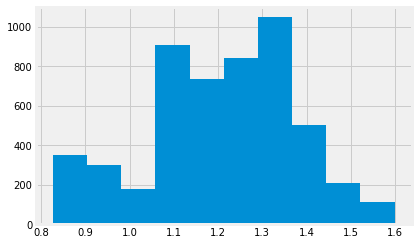

In [10]:
# Examine distribution
eurusdopen.hist()

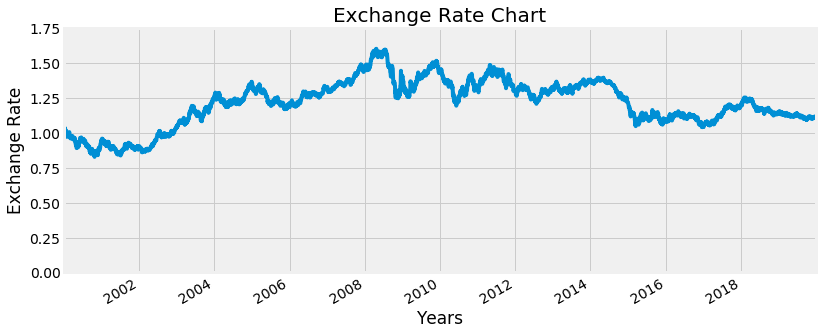

In [11]:
# Plot the exchange rate for 'open column'

eurusd['Open'].plot(ylim=[0,1.75],figsize = (12,5)).autoscale(axis='x', tight=True)
plt.title('Exchange Rate Chart', size=20)
plt.xlabel('Years', size=17)
plt.ylabel('Exchange Rate', size=17)
plt.autoscale(enable=True, axis='x', tight=True)
plt.tick_params(labelsize=14)

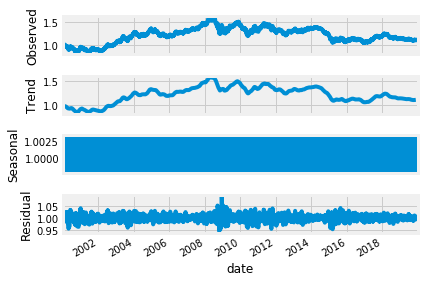

In [12]:
# Carry out Decomposition

seasonal = seasonal_decompose(eurusd.Open, model='multiplicative', freq=52)
seasonal.plot()
mpl.rcParams['figure.figsize'] = 12,6

STATIONARITY

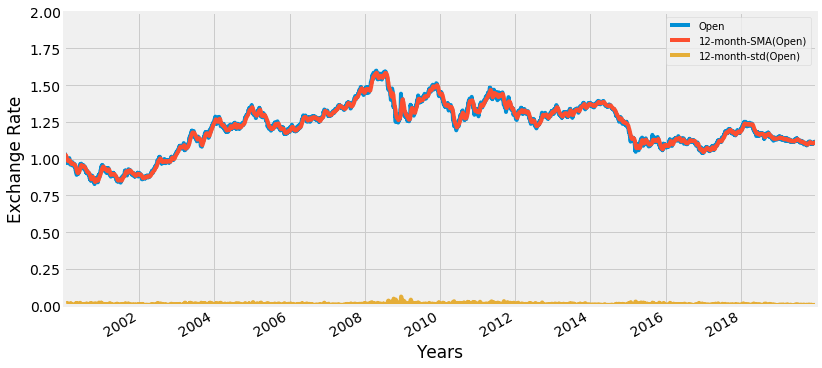

In [13]:
# Examine the trend of the mean and standard deviation to examine impact on exchange rate trend

eurusd['12-month-SMA(Open)'] = eurusd['Open'].rolling(window=12).mean()
eurusd['12-month-std(Open)'] = eurusd['Open'].rolling(window=12).std()
eurusd[['Open', '12-month-SMA(Open)', '12-month-std(Open)']].plot()
plt.ylim(0, 2)
plt.xlabel('Years', size=17)
plt.ylabel('Exchange Rate', size=17)
plt.autoscale(enable=True, axis='x', tight=True)#plt.axis('tight'
plt.tick_params(labelsize=14)
mpl.rcParams['figure.figsize'] = 12,6

From the chart above, it is clear that the Standard deviation is stationary, while the mean is not. The mean actually varies with the exchange rate trend

In [14]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [16]:
mod = sm.tsa.statespace.SARIMAX(eurusd.Open,
                                order=(1, 0, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9989      0.001   1753.875      0.000       0.998       1.000
ar.S.L12      -0.0134      0.012     -1.134      0.257      -0.037       0.010
ma.S.L12      -0.9981      0.007   -152.219      0.000      -1.011      -0.985
sigma2      5.526e-05   8.15e-07     67.829      0.000    5.37e-05    5.69e-05


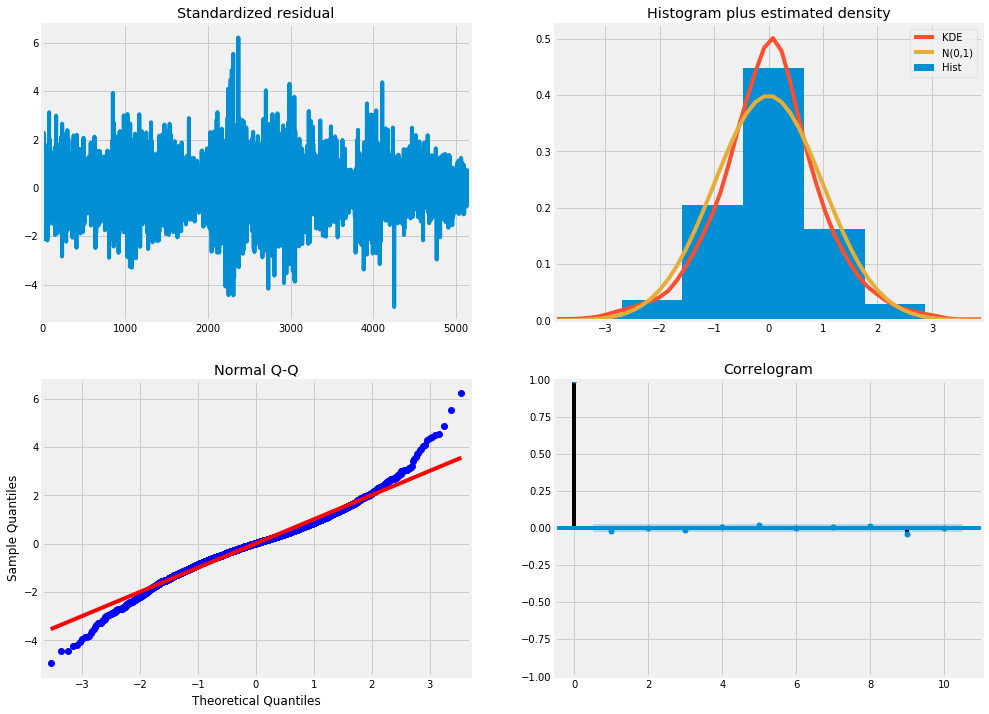

In [17]:
# Diagnostics of results
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

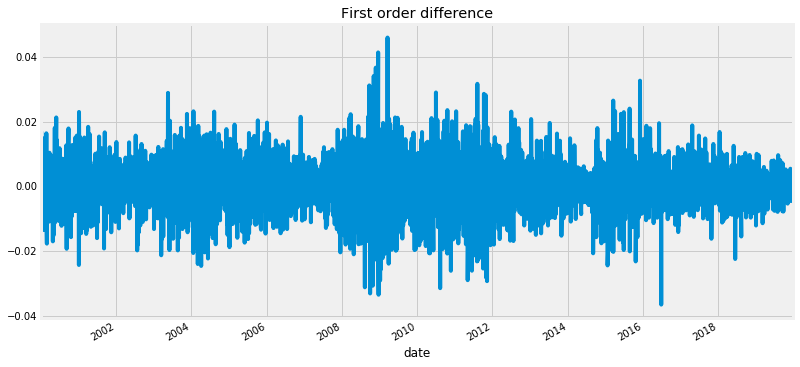

In [18]:
eurusd['d1Open'] = eurusd['Open'].diff()
eurusd['d1Open'].plot(title='First order difference').autoscale(axis='x', tight='True')

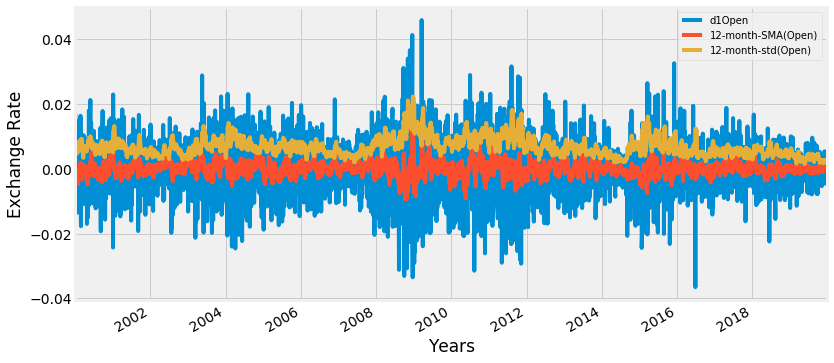

In [19]:
eurusd['12-month-SMA(Open)'] = eurusd['d1Open'].rolling(window=12).mean()
eurusd['12-month-std(Open)'] = eurusd['d1Open'].rolling(window=12).std()
eurusd[['d1Open', '12-month-SMA(Open)', '12-month-std(Open)']].plot()
plt.xlabel('Years', size=17)
plt.ylabel('Exchange Rate', size=17)
plt.autoscale(enable=True, axis='x', tight=True)#plt.axis('tight'
plt.tick_params(labelsize=14)
mpl.rcParams['figure.figsize'] = 12,6

In [20]:
print('Augmented Dickey-Fuller Test on EURUSD Exchange Rate Data')
dftest = adfuller(eurusd['Open'], autolag='AIC')
dftest

Augmented Dickey-Fuller Test on EURUSD Exchange Rate Data


(-1.7766411806819693,
 0.39211880218374784,
 0,
 5186,
 {'1%': -3.4316115772743645,
  '5%': -2.8620974851364487,
  '10%': -2.567066749257732},
 -35890.06074673519)

Hypothesis Testing:
    
The Null hypothesis of this project states that the time series data of eurysd is non-stationary. Using the Dickey fuller test, I will determine below whether or not this is true.

In [21]:
stepwise_fit = auto_arima(eurusd['Open'], start_P = 1, start_q = 1, max_p = 3, max_q = 3, m=12, start_p = 0, seasonal =True
                          , d=None, D=1, trace=True, 
                           error_action='ignore', # We don't want to know if an order does not work
                           surpress_warnings=True, #We don't want convergence warnings
                           stepwise=True) #Set to stepwise
stepwise_fit.summary()

Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=-27750.573, BIC=-27717.815, Fit time=55.518 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-23285.648, BIC=-23272.545, Fit time=2.492 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=-34037.982, BIC=-34011.776, Fit time=35.831 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-27752.181, BIC=-27725.975, Fit time=45.630 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-23287.328, BIC=-23280.776, Fit time=0.937 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-32618.739, BIC=-32599.084, Fit time=1.805 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=-34615.960, BIC=-34583.202, Fit time=184.390 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=-35597.560, BIC=-35558.250, Fit time=175.923 seconds
Near non-invertible roots for order (1, 0, 0)(2, 1, 1, 12); setting score to inf (at least one in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 5187
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood               17962.410
Date:                            Thu, 09 Jan 2020   AIC                         -35914.820
Time:                                    14:29:16   BIC                         -35882.062
Sample:                                         0   HQIC                        -35903.359
                                           - 5187                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.546e-06    1.7e-06     -1.499      0.134   -5.88e-06    7.84e-07
ar.L1          0.9959      0.001   1489.286      0.000       0.995       0.997
ar.S.L12      -0.0320      0.012     -2.617      0.009      -0.056      -0.008
ma.S.L12      -0.9989      0.010   -102.963      0.000      -1.018      -0.980
sigma2      5.715e-05   9.55e-07     59.865      0.000    5.53e-05     5.9e-05
===================================================================================
Ljung-Box (Q):                       56.49   Jarque-Bera (JB):               898.95
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
print('Augmented Dickey-Fuller Test on EURUSD Exchange Rate Data')
dfout = pd.Series(dftest[0:4], index = ['ADF Test Statistic', 'p-value', '# lags used', '# observations'])

for key, val in dftest[4].items():
    dfout[f'critical value({key})']=val
    print(dfout)

Augmented Dickey-Fuller Test on EURUSD Exchange Rate Data
ADF Test Statistic      -1.776641
p-value                  0.392119
# lags used              0.000000
# observations        5186.000000
critical value(1%)      -3.431612
dtype: float64
ADF Test Statistic      -1.776641
p-value                  0.392119
# lags used              0.000000
# observations        5186.000000
critical value(1%)      -3.431612
critical value(5%)      -2.862097
dtype: float64
ADF Test Statistic       -1.776641
p-value                   0.392119
# lags used               0.000000
# observations         5186.000000
critical value(1%)       -3.431612
critical value(5%)       -2.862097
critical value(10%)      -2.567067
dtype: float64


The P-value above is greater than 5% using the dickey fuller test, hence we accept the null-hypothesis to be true, that our time series data for eurusd is non-stationary

MACHINE LEARNING

#### SARIMAX MODEL

In [23]:
eurusd.shape

(5187, 9)

In [24]:
# Split Dataset into training and test using a 70% split in favor of train
size = int(len(eurusd.Open) * 0.70)
train, test = eurusd.Open[0:size], eurusd.Open[size:len(eurusd.Open)]

In [25]:
# Import SARIMAX 

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
# Fit SARIMAX model
model  = SARIMAX(train, order=(1,0,0), seasonal_order=(1,1,1,12), enforce_invertibility=False)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               Open   No. Observations:                 3630
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood               12301.710
Date:                            Thu, 09 Jan 2020   AIC                         -24595.420
Time:                                    14:29:28   BIC                         -24570.645
Sample:                                         0   HQIC                        -24586.593
                                           - 3630                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9983      0.001   1031.377      0.000       0.996       1.000
ar.S.L12      -0.0084      0.014     -0.583      0.560      -0.037       0.020
ma.S.L12      -0.9965      0.007   -150.509      0.000      -1.009      -0.984
sigma2      6.407e-05   1.15e-06     55.760      0.000    6.18e-05    6.63e-05
===================================================================================
Ljung-Box (Q):                       46.14   Jarque-Bera (JB):               409.46
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Make predictions
start = len(train)
end = len(train) + len(test)-1
predictions = results.predict(start = start, end = end, dynamic = False, typ='levels').rename('SARIMAX(1,0,0) Predictions')

In [28]:
# Define expected
expected=test

In [29]:
# Forcast error
for i in range(len(predictions)):
    Forecast_error = predictions[i] - test[i]

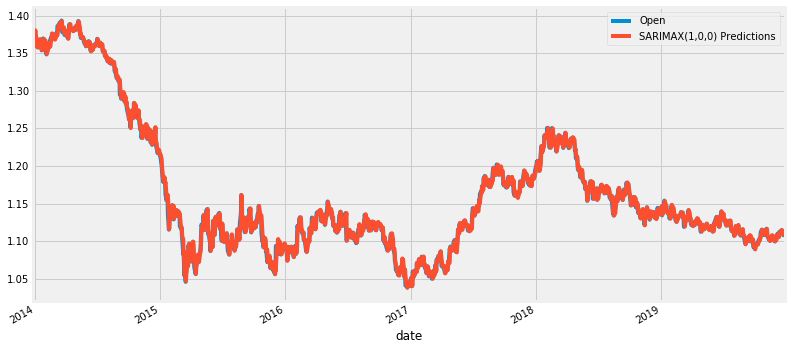

In [30]:
# Plot predictions against known values
ax = test.plot(legend=True, figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis = 'x', tight=True)

In [31]:
# Compare predictions to expected values

for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, \t expected={test[i]}")

predicted=1.368819690108401, 	 expected=1.3681
predicted=1.3686641375061241, 	 expected=1.36897
predicted=1.3696474512888783, 	 expected=1.37494
predicted=1.3753100122157849, 	 expected=1.38012
predicted=1.3801991901136041, 	 expected=1.37409
predicted=1.3742503344490633, 	 expected=1.36714
predicted=1.3676293077441162, 	 expected=1.3591
predicted=1.3581191555424457, 	 expected=1.36277
predicted=1.3629689726136092, 	 expected=1.36148
predicted=1.3609513142917011, 	 expected=1.3576
predicted=1.3574845815780257, 	 expected=1.3608
predicted=1.3599130940905815, 	 expected=1.3677
predicted=1.367169931731048, 	 expected=1.3671
predicted=1.3676870400362566, 	 expected=1.36791
predicted=1.3685573944908251, 	 expected=1.3604399999999999
predicted=1.3608067597090079, 	 expected=1.3618700000000001
predicted=1.361983707657702, 	 expected=1.3537
predicted=1.353918220147684, 	 expected=1.35509
predicted=1.355711178833444, 	 expected=1.3559999999999999
predicted=1.354999401506572, 	 expected=1.3547
p

In [32]:
# Plot predictions against known values
#expected.plot(legend=True, figsize=(12,6))
#pd.DataFrame(predictions).plot(legend=True)
#plt.autoscale(axis = 'x', tight=True)

In [33]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'SARIMAX(1,0,0) MSE Error {error}')

SARIMAX(1,0,0) MSE Error 3.488700192443124e-05


In [34]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'SARIMAX(1,0,0) RMSE Error: {error:11.10}')

SARIMAX(1,0,0) RMSE Error: 0.005906521982


#### Retrain Sarimax model

In [38]:
model = SARIMAX(eurusd['Open'], order=(1,0,0), seasonal_order=(1,1,1,12), enforce_invinsibility=False)
result2 = model.fit()
fcast = result2.predict(len(eurusd), len(eurusd)+365*10, dynamic=True, typ='levels').rename('SARIMAX(1,0,0)Forecast')

In [39]:
fcast_start = max(eurusd.index.values) + pd.Timedelta(days = 1)
fcast_end = max(eurusd.index.values) + pd.Timedelta(days = 10 * 365 + 1)
fcast = pd.DataFrame(fcast)
fcast['date'] = pd.date_range(fcast_start, fcast_end)

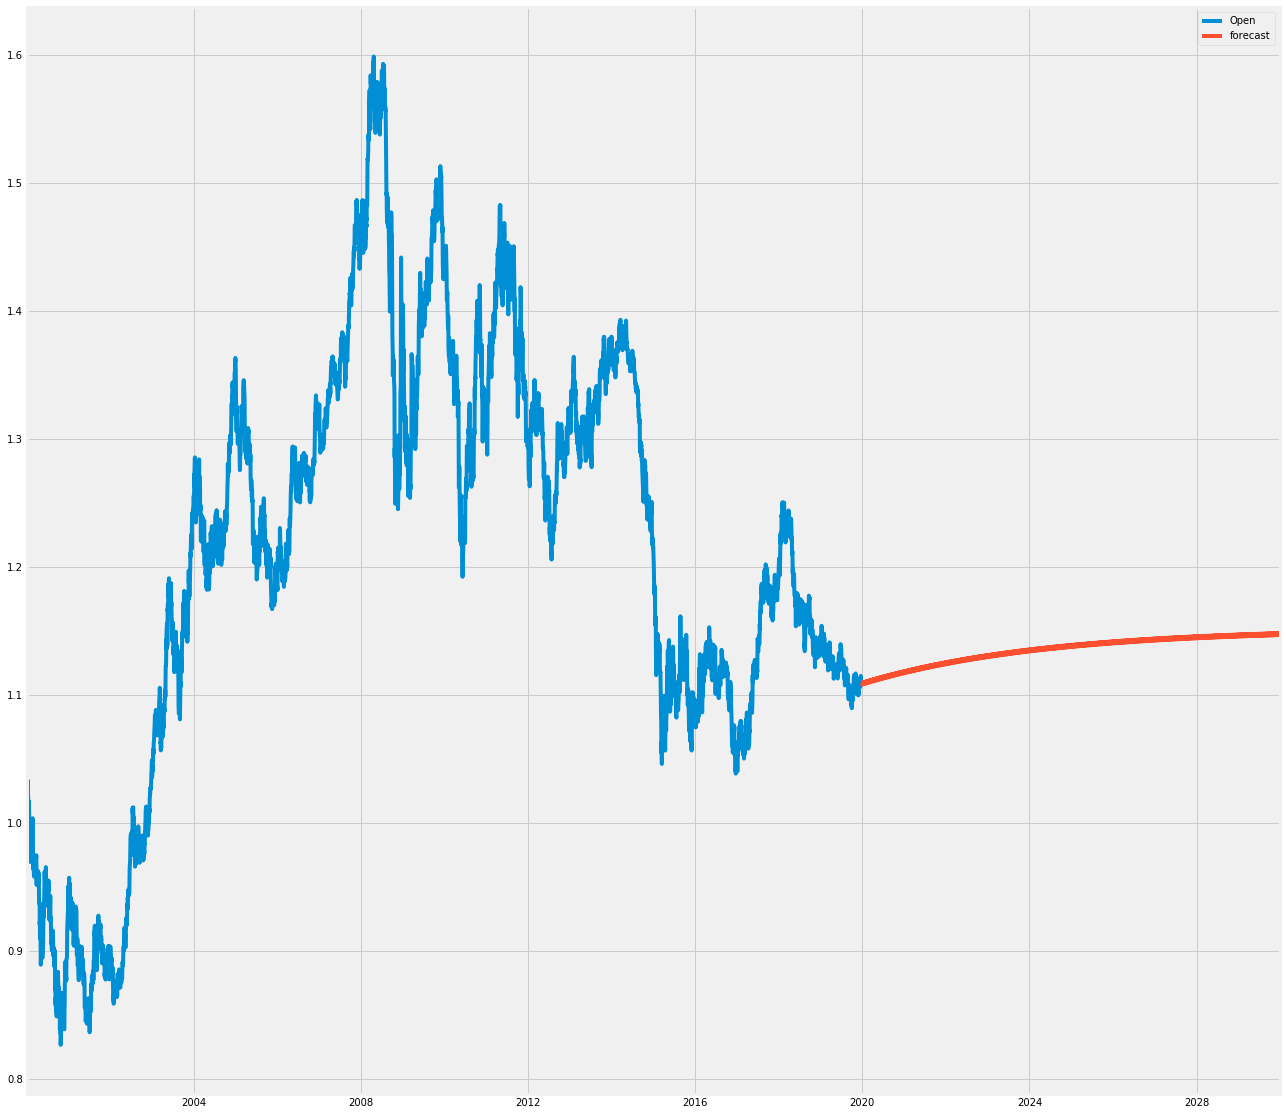

In [41]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.plot(eurusd['Open'], label = 'Open')
ax.plot(fcast.date, fcast.iloc[:, 0], label = 'forecast')
ax.legend()
ax.autoscale(axis = 'x', tight=True)
plt.show()  